# 建立算法的管道模型

<font color="blue">作者：欧新宇（Xinyu OU）</font>

<font color="red">本文档所展示的测试结果，均运行于：Intel Core i7-7700K CPU 4.2GHz</font>

## 1. 管道模型的概念及用法

**管道模型（Pipeline）**的基本功能是把一系列算法打包在一起，让他们各司其职，形成一个流水线。就像组装汽车的工厂流水线。

### 1.1 基本概念

#### 1.1.1 未使用管道模型进行训练和评估

##### - 数据载入

In [1]:
# 导入数据生成器
from sklearn.datasets import make_blobs
# 导入数据集拆分工具
from sklearn.model_selection import train_test_split
# 导入数据预处理工具
from sklearn.preprocessing import StandardScaler
# 导入多层感知机神经网络
from sklearn.neural_network import MLPClassifier
# 导入画图工具
import matplotlib.pyplot as plt

#TODO: 1.生成数据集并进行数据划分
X, y = make_blobs(n_samples=200, centers=2, cluster_std=5, random_state=16)
X_train, X_test, y_train, y_test=train_test_split(X,y,random_state=16)

#TODO: 2.数据预处理
scaler = StandardScaler().fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)
print("训练集形态：{}，测试集形态：{}".format(X_train_scaled.shape, X_test_scaled.shape))

训练集形态：(150, 2)，测试集形态：(50, 2)


> <font color="blue">这段代码中，我们选择的是MLP多层感知神经网络作为下一步要用的分类器模型，**因为MLP是典型的需要进行数据预处理的算法模型**</font>

##### - 数据的可视化

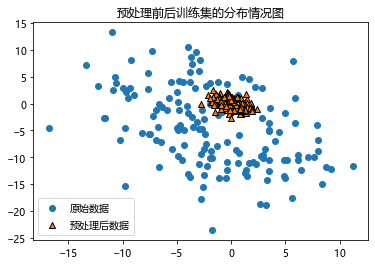

In [2]:
plt.rcParams['font.sans-serif'] = [u'Microsoft YaHei']

plt.scatter(X_train[:,0], X_train[:,1], label='原始数据')
plt.scatter(X_train_scaled[:,0], X_train_scaled[:,1], marker='^', edgecolor='k', label='预处理后数据')

plt.title('预处理前后训练集的分布情况图')
plt.legend(loc='best')
plt.show()

从上图可以看到，经过StandardScaler预处理，原数据集变得更加`聚拢`，这样更有利于使用神经网络进行拟合。

下面，我们使用`网格搜索`来确定 MLP 的最优参数，在此处我们仅选择超参数 `hidden_layer_sizes` 和 `alpha`。为了保证收敛，设置最大迭代次数`max_iter=1600`。

##### - 使用网格搜索输出评分

In [3]:
# 导入网格搜索类
from sklearn.model_selection import GridSearchCV
# 设定网格搜索的目标参数字典
params = {'hidden_layer_sizes':[[50],[100],[100,100]],
         'alpha':[0.0001, 0.001, 0.01, 0.1]}
# 建立网格搜索模型
mlp = MLPClassifier(max_iter=1600, random_state=16)
grid = GridSearchCV(mlp, param_grid=params, cv=3, iid=False, verbose=1, n_jobs=8)
# 使用网格搜索拟合数据
grid.fit(X_train_scaled, y_train)
# 输出结果
print('模型最佳得分：{:.2f}'.format(grid.best_score_))
print('模型最佳参数：{}'.format(grid.best_params_))

Fitting 3 folds for each of 12 candidates, totalling 36 fits


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


模型最佳得分：0.87
模型最佳参数：{'alpha': 0.0001, 'hidden_layer_sizes': [100]}


[Parallel(n_jobs=8)]: Done  36 out of  36 | elapsed:    7.0s finished


In [4]:
print('测试集得分：{}'.format(grid.score(X_test_scaled, y_test)))

测试集得分：0.92


**【结果分析】**

以上，我们使用了一个标准的代码实现了以下几个功能:
1. 数据载入并将数据集划分为训练集和测试集
2. 数据预处理，使用训练集拟合预处理器scaler，并用其来预处理训练集和测试集
3. 使用基于MLP的网格搜索算法及交叉验证获取最优参数并输出交叉验证评分
4. 利用交叉验证获得的参数在测试集上进行预测

在以上过程中存在一个很隐藏的问题。
- 首先， 我们在使用交叉验证的时候，会将输入到GridSearchCV中的训练集X_train_scaled进行拆分，划分为训练集`Grid_train`和验证集`Grid_val`。在训练模型的过程中，我们一直有一个原则：**测试集永远不能参与训练中，只能用于最终的评估**。
- 其次，在进行最初的数据预处理的时候，我们使用`整个训练集`X_train_scaled去拟合`预处理器` **scaler**，这就意味着`Grid_val`被用来参与训练 **scaler**。
- 然后，我们又用基于Grid_val训练的预处理器 **scaler** 来拟合在交叉验证中作为验证集（或者称为测试集）的`Grid_val`，这就违背了之前的原则。
> 因此，前面的训练过程会导致交叉验证的结果出现偏差。

那怎么办呢？一个容易理解的方式是：
1. 针对每一组**参数对**，我们都执行一次数据拆分，并在拆分数据的时候，直接就将数据拆分成三部分，`训练集new_train`、`验证集new_val`、`测试集new_test`; 
2. 然后用此处生成的训练集new_train来训练预处理器scaler，并用scaler来拟合证集new_val、测试集new_test; 
3. 接下来再使用被与处理过的new_train和new_val来进行交叉验证和网格搜索。
4. 之后再将训练集new_train、验证集new_val合并成 new_trainval，并保持网格搜索的最优参数不变，训练新的模型；
5. 最后在用新的模型在新测试集new_test上输出最终评分。

此处，看起来非常流畅，但是存在一个问题。在第三步中，由于我们使用的是 ***K*折交叉验证**，这就意味着在每次训练的过程中训练集new_train和验证集new_val是不同的（实际上，不管是那种交叉验证方法，都会有这样的问题，例如留一法），这样就会产生new_train1,new_train2,...;new_val1,new_val2,...。很显然这样的操作是没有问题，但是代码会变得非常繁琐。

> `复杂的代码` 还是 `不可行的交叉验证评分`？ 

**管道模型Pipeline**可以解决这个问题。管道模型会在每次进行交叉验证的时候，都重新对trainval进行拆分，并分别对训练集pipe_train进行预处理，然后再用生成的scale对验证集pipe_val进行拟合。使用管道模型我们可以非常简单的代码实现刚刚的需求。

**<font color="red">值得注意的是：管道模型的执行过程和我们刚刚分析的过程是一致的，只是它被更好地封装成了一个类，同时支持并行处理等优化算法，让程序员只需要调用Pipeline接口就可以实现复杂的循环操作。</font>**



#### 1.1.2 使用管道模型实现训练和评分

In [5]:
# 导入管道模型
from sklearn.pipeline import Pipeline
# 建立包含预处理和神经网络的管道模型
pipeline = Pipeline([('scaler',StandardScaler()),
                     ('mlp',MLPClassifier(max_iter=1600,random_state=38))])
# 使用管道模型对训练集进行拟合
pipeline.fit(X_train, y_train)
print('使用管道模型的MLP模型评分：{:.2f}'.format(pipeline.score(X_test,y_test)))

使用管道模型的MLP模型评分：0.92


**【结果分析】**


可以看出管道模型输出的 `x_test` 上的结果和不使用管道模型输出的结果是不同（不排除在某些情况下会有相同的结果），这里主要的原因是不使用管道模型的代码存在不可信的问题。

<font style="font-weight:bold;color:red;">Why?</font> 

> 大家自行思考。

下面我们再尝试将管道模型和网格搜索整合在一起，用于搜索最佳参数。

### 1.2 使用管道模型进行网格搜索

In [6]:
# 导入数据生成器
from sklearn.datasets import make_blobs
# 导入数据集拆分工具
from sklearn.model_selection import train_test_split
# 导入数据预处理工具
from sklearn.preprocessing import StandardScaler
# 导入多层感知机神经网络
from sklearn.neural_network import MLPClassifier

from sklearn.model_selection import GridSearchCV# 导入管道模型
from sklearn.pipeline import Pipeline

#TODO: 1.生成数据集并进行数据划分
X, y = make_blobs(n_samples=200, centers=2, cluster_std=5, random_state=16)
X_train, X_test, y_train, y_test=train_test_split(X,y,random_state=16)

#TODO: 2.创建管道模型，并创建预处理模块scaler和神经网络模块mlp
params = {'mlp__hidden_layer_sizes':[[50],[100],[100,100]],
          'mlp__alpha':[0.0001, 0.001, 0.01, 0.1]}

pipeline = Pipeline(steps=
                    [('scaler', StandardScaler()),
                     ('mlp', MLPClassifier(max_iter=1600, random_state=16))], verbose=1)

# TODO: 3.创建网格搜索模型，并输出预测结果
grid = GridSearchCV(pipeline, param_grid=params, cv=5, iid=False, n_jobs=8, verbose=1)
grid.fit(X_train, y_train)
print('交叉验证评分:{:.2f}'.format(grid.best_score_))
print('模型最优参数：{}'.format(grid.best_params_))
print('测试集得分：{}'.format(grid.score(X_test,y_test)))

Fitting 5 folds for each of 12 candidates, totalling 60 fits


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    4.6s


[Pipeline] ............ (step 1 of 2) Processing scaler, total=   0.0s
[Pipeline] ............... (step 2 of 2) Processing mlp, total=   0.1s
交叉验证评分:0.87
模型最优参数：{'mlp__alpha': 0.0001, 'mlp__hidden_layer_sizes': [100]}
测试集得分：0.92


[Parallel(n_jobs=8)]: Done  60 out of  60 | elapsed:    8.9s finished


**【结果分析】**

> Fitting 5 folds for each of 12 candidates, totalling 60 fits

从上面的输出结果，可以看到交叉验证总共5次拆分（cv=5），12次候选（3种隐层尺寸mlp__hidden_layer_sizes，4种L2正则化指数mlp__alpha，总共$3 \times 4=12$种），意味着程序总共进行了$5 \times 12=60次$。在参数代码params中的两个参数`mlp__hidden_layer_sizes`和`mlp__alpha`都有一个公共的参数前缀`mlp__`，这说明在**管道pipeline**中可以封装多个不同的模型，这些模型相互独立，在进行基于管道的流水线运作中，是被独立处理的。在本例中，输入到管道中的包含了两个模型，分别是 `scaler__` 和 `mlp__`，而模型 `mlp__` 包含了两个参数 `hidden_layer_sizes` 和 `alpha`。这种前缀的设计方法，让管道程序可以同时使用多个不同的模型，而这些模型相互独立，从而实现可交叉、可并行、可复用的流水线。

值得注意的是，在使用 `GridSearchCV` 进行交叉验证的时候，系统会默认将`训练集train` 拆分成 `训练集X_trainCV` + `验证集X_valCV`，并进行训练和评估。其中交叉验证得分就是基于验证集的评价结果。但是该结果使用的模型是拆分后的`训练集X_trainCV`，而不是`原始的训练集X_train`。

下面给出流水线的处理过程透视。


In [7]:
print(pipeline.steps)

[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('mlp', MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=(100,), learning_rate='constant',
              learning_rate_init=0.001, max_iter=1600, momentum=0.9,
              n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
              random_state=16, shuffle=True, solver='adam', tol=0.0001,
              validation_fraction=0.1, verbose=False, warm_start=False))]


## 2. 管道模型案例——股票涨跌分析

### 2.1 数据载入

为了更好地介绍管道模型的用法，下面我们使用一个来自真实世界的数据集进行演示——中国股票市场的股价涨跌数据集。该数据集是`2020年2月15日`收盘之后从证券交易软件中导出的数据。按照惯例，对于新数据集我们还是先了解数据集的基本情况。

> 数据集下载地址：http://ouxinyu.cn/Teaching/MachineLearning/Datasets/stock.xls

> <font color="red">注意把数据保存到合适的位置。</font>

下面我们使用数据分析工具pandas来载入保存在excel中的股票数据集，基本流程如下：
1. 使用pandas.read_excel()函数读取excel数据源
2. 使用display()观察数据集的内容
3. 我们选定属性列`涨跌`作为回归分析的目标，`幅度%`及以后的属性列作为特征。因此我们将前者赋值给 $y$，后者赋值给 $X$
4. 查看一下数据的形状，我们总共载入了3776个样本，每个样本10个特征。

#### 2.1.1 数据载入

In [1]:
import pandas as pd
stocks = pd.read_excel('../Datasets/stock.xls')
X = stocks.loc[:, '幅度%':'昨收']
y = stocks['涨跌']
print(X.shape, y.shape)

(3776, 10) (3776,)


In [9]:
display(stocks)

,次序,名称,代码,最新,涨跌,幅度%,买一价,卖一价,市盈率,市净率,换手率,开盘,总量,强弱度,昨收
0,1,浦发银行,600000,10.86,0.10,0.929368,10.86,10.87,5.411061,0.663867,0.079564,10.76,22360549,0.552915,10.76
1,2,白云机场,600004,15.81,0.11,0.700637,15.80,15.81,42.833920,2.064804,0.289747,15.70,5995797,0.324184,15.70
2,3,东风汽车,600006,3.87,-0.03,-0.769231,3.87,3.88,17.479675,1.059229,0.398845,3.86,7976900,-1.145684,3.90
3,4,中国国贸,600007,14.89,0.10,0.676133,14.88,14.89,15.224949,2.044403,0.142383,14.81,1434202,0.299679,14.79
4,5,首创股份,600008,3.21,-0.03,-0.925926,3.21,3.22,24.189903,1.672223,0.413848,3.26,23529129,-1.302379,3.24
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3771,3772,泰林生物,300813,64.62,-3.58,-5.249267,64.61,64.62,99.430688,8.034915,32.202915,69.30,4186379,-5.727806,68.20
3772,3773,玉禾田,300815,75.58,-2.12,-2.728443,75.57,75.58,32.793857,5.558457,27.911775,76.98,9657474,-3.206982,77.70
3773,3774,艾可蓝,300816,42.75,3.89,10.010293,42.75,0.00,32.029670,5.333483,0.608975,42.75,121795,9.531754,38.86
3774,3775,耐普矿机,300818,0.00,0.00,0.000000,0.00,0.00,30.823053,2.792886,0.000000,0.00,0,0.000000,33.48


#### 2.1.2 数据预拆分

下面我们使用train_test_split()将数据拆分成`训练集`和`测试集`，其中训练集比例为**60%**。注意此处我们整个例子使用统一的随机种子random_state=26。

<font color="red">注意：尽管本课程的教材很多地方都没有区分训练集和测试集，但是我们尽量这样做，因为在实际应用中，这是必不可少的工作和思维方式。</font>


In [2]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test=train_test_split(X,y,random_state=26, train_size=0.7)
print(X_train.shape, X_test.shape)

(2643, 10) (1133, 10)


### 2.2 使用交叉验证输出验证集评分

#### 2.2.1 直接进行交叉验证和模型训练

In [11]:
from sklearn.model_selection import cross_val_score
from sklearn.neural_network import MLPRegressor

scores = cross_val_score(MLPRegressor(random_state=26),X_train,y_train,cv=3)
print ('交叉验证平均分：{:.2f}'.format(scores.mean()))

交叉验证平均分：-21672679.54


**【结果分析】**

模型在验证集上交叉验证的评分为负数，而且绝对值相当大（-2000多万），这说明模型的评价结果差得离谱。主要原因是数据的**量纲**差异太大（注意观察`display(stocks)`输出的数据集内容）。所以，我们需要对原始数据进行预处理，最常见的处理方法是将数据集的均值置为零，方差置为1，我们可以使用StandardScaler()来进行处理。

下面的代码给出预处理后的数据形态展示：

In [12]:
from sklearn.preprocessing import StandardScaler
scaler=StandardScaler().fit(X_train)
X_scaled= scaler.transform(X_train)
print(X_scaled[0])

[-0.05891796 -0.42075602 -0.41380007 -0.09455137 -0.18253657 -0.56089547
 -0.41994736 -0.38832281  0.09327087 -0.38503237]


#### 2.2.2 使用管道模型进行交叉验证和模型训练

我们定义一个管道模型pipe，并在这个管道中定义两个不同的模型，一个是用于预处理的 `scaler`，另一个适用于回归训练的 `mlp`。

In [13]:
# 导入数据预处理工具
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

# 方法一：
pipe = Pipeline([('scaler',StandardScaler()), 
                 ('mlp',MLPRegressor(random_state=26, max_iter=800))])
print(pipe.steps)

# 方法二:
from sklearn.pipeline import make_pipeline
pipe = make_pipeline(StandardScaler(), MLPRegressor(random_state=16, max_iter=2000))
print(pipe.steps)

[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('mlp', MLPRegressor(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
             beta_2=0.999, early_stopping=False, epsilon=1e-08,
             hidden_layer_sizes=(100,), learning_rate='constant',
             learning_rate_init=0.001, max_iter=800, momentum=0.9,
             n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
             random_state=26, shuffle=True, solver='adam', tol=0.0001,
             validation_fraction=0.1, verbose=False, warm_start=False))]
[('standardscaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('mlpregressor', MLPRegressor(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
             beta_2=0.999, early_stopping=False, epsilon=1e-08,
             hidden_layer_sizes=(100,), learning_rate='constant',
             learning_rate_init=0.001, max_iter=2000, momentum=0.9,
             n_iter_no_change=10, nesterovs_momentum=True, p

In [14]:
scores = cross_val_score(pipe,X_train,y_train,cv=3)
print('交叉验证平均分：{:.2f}'.format(scores.mean()))

pipe.fit(X_train, y_train)
print('测试集评分：{:.2f}'.format(pipe.score(X_test,y_test)))

交叉验证平均分：0.86
测试集评分：0.86


**【结果分析】**

相比没有进行预处理的评分，我们拿到了一个理想的值，验证集平均分0.86，测试集0.86。说明预处理在这个任务中非常有效。

值得注意的是，在创建管道模型的时候，我们有两种方法，一种是使用pipeline()类，另一种是使用make_pipeline()类，这两种方法具有完全相同的结果。后者相对简单，不需要写出步骤的名称。

### 2.3 使用管道模型进行模型选择和参数调优

### 2.3.1 使用管道模型进行模型选择

下面给出两个模型，一个是基于神经网络的回归器，一个是基于随机森林的回归器，我们利用pipeline来自动选择并输出最优模型。

In [10]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline


#下面对pipeline进行实例化
pipe = Pipeline([('scaler',StandardScaler()),('reg',RandomForestRegressor())])
params = [{'reg':[MLPRegressor(random_state=26, max_iter=800)],
           'scaler':[StandardScaler(),None]},
         {'reg':[RandomForestRegressor(random_state=26, n_estimators=10)],
          'scaler':[None]}]

grid = GridSearchCV(pipe, params, cv=3)
grid.fit(X_train,y_train)

print('最佳模型是：\n{}'.format(grid.best_params_))
print('交叉验证平均分:{:.2f}'.format(grid.best_score_))
print('测试集评分：{:.2f}'.format(grid.score(X_test,y_test)))

最佳模型是：
{'reg': MLPRegressor(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
             beta_2=0.999, early_stopping=False, epsilon=1e-08,
             hidden_layer_sizes=(100,), learning_rate='constant',
             learning_rate_init=0.001, max_iter=800, momentum=0.9,
             n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
             random_state=26, shuffle=True, solver='adam', tol=0.0001,
             validation_fraction=0.1, verbose=False, warm_start=False), 'scaler': StandardScaler(copy=True, with_mean=True, with_std=True)}
交叉验证平均分:0.88
测试集评分：0.83


In [ ]:
最佳模型是：
{'reg': MLPRegressor(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
             beta_2=0.999, early_stopping=False, epsilon=1e-08,
             hidden_layer_sizes=(100,), learning_rate='constant',
             learning_rate_init=0.001, max_iter=800, momentum=0.9,
             n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
             random_state=26, shuffle=True, solver='adam', tol=0.0001,
             validation_fraction=0.1, verbose=False, warm_start=False), 'scaler': StandardScaler(copy=True, with_mean=True, with_std=True)}
交叉验证平均分:0.88
测试集评分：0.83

**【结果分析】**

上例中，我们给出了最佳模型的输出 `best_params` 和模型最佳得分 `best_score`。经过运行后，我们可以得到以下结论：
1. 我们输入了两个模型，分别是`多层感知机回归器` MLPRegressor和`随机森林回归器`RandomForestRegressor，而输出的最佳模型只有一个 MLPRegressor，说明`多层感知机回归器`的性能要比`随机森林回归器`**更好**。在输出模型的时候，同时也输出了该模型的参数。
2. 在输入的两个模型中，都有两个子模块，一个是`回归器`，一个是`预处理器`。从代码中可以看出：
    - 对于*多层感知机 MLPRegressor 模型*，包含了一个回归器和一个预处理器 scaler，并且指定了预处理的算法 StandardScaler()；
    - 对于*随机森林 RandomForestRegressor 模型*，同样也包含了一个回归器，但是在预处理器 scaler 后面的参数是 **[None]** ，这意味着随机森林并没有使用预处理功能。
   
   从这一点上，我们可以得出一个结论，那就是神经网络是一种严重依赖于`预处理`的算法，而随机森林对`预处理`的需求并不高。

#### 2.3.2 使用管道模型寻找最优参数

在上面的例子中，我们在默认参数下进行模型选择。接下来，我们在pipeline管道模型中为两个回归模型增加参数选择功能，期望能够对两个模型都赋予不同的参数，并对比每个模型的性能，最后输出具有最优性能的模型。

- 首先，为MLP增加隐层单元参数，为随机森林增加树数参数
```python
'reg__hidden_layer_sizes':[[50],[100],[100,100]]
    
'reg__n_estimators':[10,50,100]
```


In [16]:
params = [{'reg':[MLPRegressor(random_state=26, max_iter=800)],
          'scaler':[StandardScaler(),None],
          'reg__hidden_layer_sizes':[[50],[100],[100,100]]},
         {'reg':[RandomForestRegressor(random_state=26)],
         'scaler':[None],
         'reg__n_estimators':[10,50,100]}]
# pipe = make_pipeline(StandardScaler(),
#                 MLPRegressor(random_state=26))
pipe = Pipeline([('scaler',StandardScaler()),('reg',MLPRegressor())])
grid = GridSearchCV(pipe, params, cv=3)
grid.fit(X_train,y_train)

print('最佳模型是：\n{}'.format(grid.best_params_))
print('交叉验证平均分:{:.2f}'.format(grid.best_score_))     
print('测试集评分：{:.2f}'.format(grid.score(X_test,y_test)))

最佳模型是：
{'reg': MLPRegressor(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
             beta_2=0.999, early_stopping=False, epsilon=1e-08,
             hidden_layer_sizes=[100, 100], learning_rate='constant',
             learning_rate_init=0.001, max_iter=800, momentum=0.9,
             n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
             random_state=26, shuffle=True, solver='adam', tol=0.0001,
             validation_fraction=0.1, verbose=False, warm_start=False), 'reg__hidden_layer_sizes': [100, 100], 'scaler': StandardScaler(copy=True, with_mean=True, with_std=True)}
交叉验证平均分:0.91
测试集评分：0.97


- 其次，我们增大随机森林的树数参数

```python  
'reg__n_estimators':[100,500,1000]}
```

In [17]:
params = [{'reg':[MLPRegressor(random_state=26, max_iter=800)],
          'scaler':[StandardScaler(),None],
          'reg__hidden_layer_sizes':[[50],[100],[100,100]]},
         {'reg':[RandomForestRegressor(random_state=26)],
         'scaler':[None],
         'reg__n_estimators':[100,500,1000]}]
pipe = Pipeline([('scaler',StandardScaler()),('reg',MLPRegressor())])
grid = GridSearchCV(pipe, params, cv=3)
grid.fit(X_train,y_train)

print('最佳模型是：\n{}'.format(grid.best_params_))
print('交叉验证平均分:{:.2f}'.format(grid.best_score_))           
print('测试集评分：{:.2f}'.format(grid.score(X_test,y_test)))

最佳模型是：
{'reg': MLPRegressor(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
             beta_2=0.999, early_stopping=False, epsilon=1e-08,
             hidden_layer_sizes=[100, 100], learning_rate='constant',
             learning_rate_init=0.001, max_iter=800, momentum=0.9,
             n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
             random_state=26, shuffle=True, solver='adam', tol=0.0001,
             validation_fraction=0.1, verbose=False, warm_start=False), 'reg__hidden_layer_sizes': [100, 100], 'scaler': StandardScaler(copy=True, with_mean=True, with_std=True)}
交叉验证平均分:0.91
测试集评分：0.97


- 最后，我们输出随机森林的评分，用于和MLP的性能进行对比

In [21]:
pipe = Pipeline([('scaler',StandardScaler()),('reg',RandomForestRegressor())])

params = [{'reg':[RandomForestRegressor(random_state=26)],
         'scaler':[StandardScaler(),None],
         'reg__n_estimators':[100,500,1000]}]
grid = GridSearchCV(pipe, params, cv=3, verbose=1)
grid.fit(X_train,y_train)

print('最佳模型是：\n{}'.format(grid.best_params_))
print('交叉验证平均分:{:.2f}'.format(grid.best_score_))           
print('测试集评分：{:.2f}'.format(grid.score(X_test,y_test)))

Fitting 3 folds for each of 6 candidates, totalling 18 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  18 out of  18 | elapsed:  1.0min finished


最佳模型是：
{'reg': RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=500,
                      n_jobs=None, oob_score=False, random_state=26, verbose=0,
                      warm_start=False), 'reg__n_estimators': 500, 'scaler': StandardScaler(copy=True, with_mean=True, with_std=True)}
交叉验证平均分:0.85
测试集评分：0.93


**【结果分析】**

结果有一点点令人疑惑的地方，那就是测试集总是比交叉验证评分更好，这通常是不正常的。产生这个问题的原因可能是模型出现了欠拟合问题，但是又由于数据较小的所以在划分数据集的时候，正好测试数据更为简单一些。

总的来说，机器学习算法对数据非常敏感，要获得较好的性能并不容易。需要丰富的调参经验。这一方面是算法简单带来的不确定性；另一方面也是因为数据量较少带来的学习不足问题。所以在过去的几十年，机器学习并没有被广泛使用，更没有被大面积商用。随着大数据时代的到来，以及深度学习算法的出现，这些问题逐渐消失。

可以说，深度学习+大数据+GPU并行运算，是人工智能得以广泛推广的关键、核心和必要因素。
